# Get all data from a variable (TEMP or PSAL) for all instruments on a Site
## Using the THREDDS service

The user has to specify the name of the station according to the AODN THREDDS catalog structure under the ANMN (e.g.QLD/GBRPPS) and the variable of interest (TEMP or PSAL) 

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import threddsclient
from ggplot import *



/home/eklein/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/eklein/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/eklein/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Setup the site name and the variable name. The variable must be one of TEMP or PSAL

In [125]:

############
site = 'QLD/GBRMYR'                  ######  <-------- change the station name HERE
variableOfInterest = 'TEMP'          ######  <-------- change the name of the variable HERE
############


## the variable name is a dictionary entry under the keys 'name' and 'nameQC'
variableName = {'name': variableOfInterest,
                'nameQC': variableOfInterest + '_quality_control'}

print(variableName)

{'name': 'TEMP', 'nameQC': 'TEMP_quality_control'}


### Get the list of files from the THREDDS server

In [126]:
## Catalogue url

PPcatalogueURL = 'http://thredds.aodn.org.au/thredds/catalog/IMOS/ANMN/' + site + '/Temperature/catalog.html'

## read URLs
urls = threddsclient.opendap_urls(PPcatalogueURL)
print('Number of files: ' + str(len(urls)))


Number of files: 126


### Initialise the metadata (MD) variables

In [127]:
MD_sitecode = []
MD_deploymentcode = []
MD_longitudeMean = []
MD_latitudeMean = []
MD_longitudeAll = []
MD_latitudeAll = []
MD_timecoverageStart = []
MD_timecoverageEnd = []
MD_instrumentSN = []
MD_instrumentname = []

### Initialise the DATA variables

In [128]:
DATA_var = np.empty([0])
DATA_varQC = np.empty([0])
DATA_time = np.empty([0], dtype='datetime64[ns]')
DATA_depth = np.empty([0])
DATA_depthQC = np.empty([0])
DATA_depthNominal = np.empty([0])

DATA_deploymentCode = np.empty([0], dtype='str')
DATA_instrumentSN = np.empty([0], dtype='str')

## to get the coords of the variable. It is probably variable 
DATA_coordinates = []

### Loop over the files and collect the variable of interest

In [129]:


for i in range(0, len(urls)-1):
    nc = xr.open_dataset(urls[i])

    ## check if variable name is in the file
    ncNames = dict(nc.data_vars)
    if variableName['name'] in ncNames:
        ## print(i)
        
        ## collect the attributes
        MD_attr = nc.attrs
        MD_sitecode.append(MD_attr['site_code'])
        MD_deploymentcode.append(MD_attr['deployment_code'])
        MD_longitudeAll.append(MD_attr['geospatial_lon_min'])
        MD_latitudeAll.append(MD_attr['geospatial_lat_min'])
        MD_timecoverageStart.append(MD_attr['time_deployment_start']) 
        MD_timecoverageEnd.append(MD_attr['time_deployment_end'])
        MD_instrumentSN.append(MD_attr['instrument_serial_number'])
        MD_instrumentname.append(MD_attr['instrument'])
        
        
        ## collect coords of the variable
        DATA_coordinates.append(list(nc.TEMP.coords))
        
        ## collect DATA
        DATA_time = np.concatenate((DATA_time, nc.TIME.values.reshape(-1)))
        DATA_var = np.concatenate((DATA_var, nc[variableName['name']].values.reshape(-1)))
        DATA_varQC = np.concatenate((DATA_varQC, nc[variableName['nameQC']].values.reshape(-1)))
        
        ## Collect DEPTH. It could be a variable or a dimension!
        ## check if there is a variable DEPTH in the variable list
        if 'DEPTH'in ncNames:
            DATA_depth = np.concatenate((DATA_depth, nc.DEPTH.values.reshape(-1)))
        else:
            DATA_depth = np.repeat(float(nc.attrs['instrument_nominal_depth']), len(DATA_var))
            
        
        ## collect instrument nominal depth and make an array with length of the variable TS
        DATA_depthNominal = np.concatenate((DATA_depthNominal, np.repeat(float(nc.attrs['instrument_nominal_depth']), len(nc.TIME))))
        
        ## collect the Instrument serial number and deployment code
        DATA_deploymentCode = np.concatenate((DATA_deploymentCode, np.repeat(nc.attrs['deployment_code'], len(nc.TIME))))
        DATA_instrumentSN = np.concatenate((DATA_instrumentSN, np.repeat(nc.attrs['instrument_serial_number'], len(nc.TIME))))
        
        


        
    else:   ## in case the variable is not in the file, skip and print a message
        print('NO ' + variableName['name'] + ' in the file ' + urls[i])



Verify that the variable vector has the same dimension (length) of time and quality_control vectors

In [130]:
print('TIME: '+ str(DATA_time.shape))
print(variableName['name'] + ': ' + str(DATA_var.shape))
print(variableName['nameQC'] + ': ' + str(DATA_varQC.shape))
print('DEPTH: ' + str(DATA_depth.shape))
print('NominalDepth: ', str(DATA_depthNominal.shape))
print('DeploymentCode: ' + str(DATA_deploymentCode.shape))
print('Serial Number: ' + str(DATA_instrumentSN.shape))

TIME: (25384374,)
TEMP: (25384374,)
TEMP_quality_control: (25384374,)
DEPTH: (25384374,)
NominalDepth:  (25384374,)
DeploymentCode: (25384374,)
Serial Number: (25384374,)


### Plot the time series

Converting variable and time to `pandas Series` object. Filter the data with QC flag <=2 (good/probably good data)

In [131]:
## Create pandas DataFrame. 
data = {'TIME': DATA_time[DATA_varQC>=1], 
        'TEMP': DATA_var[DATA_varQC>=1], 
        'TEMPQC': DATA_varQC[DATA_varQC>=1], 
        'depthNOMINAL': DATA_depthNominal[DATA_varQC>=1]}

df = pd.DataFrame(data)

df.head()

,TEMP,TEMPQC,TIME,depthNOMINAL
0,26.1668,3.0,2008-06-19 08:00:00.000003328,100.0
1,26.1377,3.0,2008-06-19 08:04:59.999995648,100.0
2,26.0225,3.0,2008-06-19 08:09:59.999997696,100.0
3,25.6891,3.0,2008-06-19 08:15:00.000000000,100.0
4,25.8304,3.0,2008-06-19 08:20:00.000002304,100.0


### Write csv file

In [133]:
## write csv file
df.to_csv('tempAll.csv', index=False)

In [ ]:
## make a ggplot

## pp = ggplot(aes(x='TIME', y='TEMP'), data=df)
## pp + geom_line() 

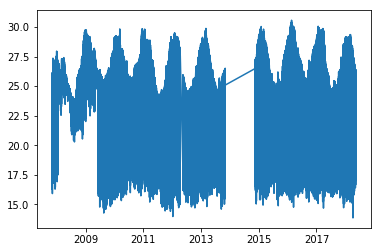

In [132]:
## create a pandas Series object only with good/probably good data
s = pd.Series(DATA_var[DATA_varQC<=2], index=DATA_time[DATA_varQC<=2])
s = s.sort_index()   ## sort the series in case the index is not in chronological order)

## plpot the series
plt.plot(s)
plt.show()